In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats
import random
from scipy.stats import norm

**Problem Statement**:  
Given the data, determine the net annual renenvue of Blue Chip Cafe.

**Variables and parameters**:  
| Description | Symbol | Units | Type|
|-------------|--------|-------|-----|
|Daily temperature | $T$ | $\degree C$ | Random variable|
|Number of Customer (daily)| $C$ | $person$ | Random variable|
|Daily precipitation| $P$| $millimeters$ | Random variable|
|Net annual revenue |$R$ | $\$$ | Random variable|
|Income per customer's purchace |$C_i$ | $\$$ | parameter|
|Cost per customer's purchase |$C_c$ | $\$$ | parameter|
|Maintenance Costs |$C_m$ | $\$$ | parameter|
|Coefficient of change of customers per change of temperature |$a$ | $\frac{person}{\degree C}$ | parameter|
|Coefficient of change of customers per change of precipitation |$b$ | $\frac{person}{millimeters}$ | parameter|
|Uncertainty in a| $\varepsilon_{a}$ | $1$ | Random variable|
|Uncertainty in b| $\varepsilon_b$ | $1$ | Random variable|

**Assumptions and Constraints:**  
***Assumptions:***  
- The uncertainty associated with each parameter is normally distributed with mean $0$ and $\sigma$ equal to the level of uncertainty.
- The Blue Chip does not run out of food or drink to sell.
- The Cafe is open all year (expect for the 13 days for holidays)
- Customer count depends linearly on deviations in temperature and precipitation. 
- Temperature and precipitation independently influence customer count, without any interactive effects (e.g., increased impact of precipitation on warmer days).
- The March 2024 customer frequency data is assumed to reflect general customer behavior across the year.   

***Constraints:***  
- Final customer count is constrained to be non-negative.
- Each customer would pay only for one drink and one cookie.
- The price for drink is \$3.17, and the price for a cookie is \$3.
- The maintainance cost is a yearly cost


**Build Solutions:**  
The Net Income is:
\begin{align*}
\textrm{Net Income} 
& = R \\
& = \textrm{Total Revenue} - \textrm{Total Costs}\\
& = (365-13)*C*(C_i) - ((365-13)*C*(C_c)+C_m)\\
& = 352*C*(C_i) - (352*C*(C_c)+C_m)\\
\end{align*}

We then define the following:
\begin{align*}
C(T,P) &= max\{c(T,P),0\}\\
c(T,P) &= C_0 + a(T-T_0)-b(P-P_0)\\
\hat{a} &= a + \varepsilon_{a}\\
\hat{b} &= b + \varepsilon_b\\
\hat{C}(T,P) &= max\{\hat{c}(T,P),0\}\\
\hat{c}(T,P) &= C_0 + \hat{a}(T-T_0)-\hat{b}(P-P_0)\\
\end{align*}

where
\begin{align*}
\varepsilon_{N_p} &\sim \mathcal{N}(0,1^2)\\
\varepsilon_c &\sim \mathcal{N}(0,2^2)\\
\end{align*}

The model is then:

$$ R = 352*\hat{C}*(C_i) - (352*\hat{C}*(C_c)+C_m)$$

In [2]:
customer_df = pd.read_csv('data/customer.csv')

customer_df.head()

,Hour,Monthly_Frequency_Customers
0,7,259
1,8,250
2,9,346
3,10,335
4,11,722


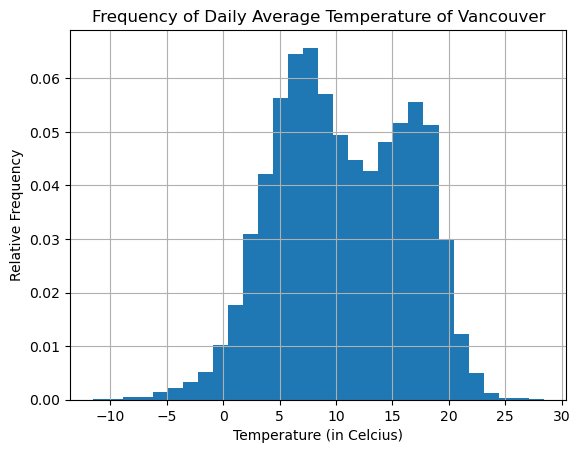

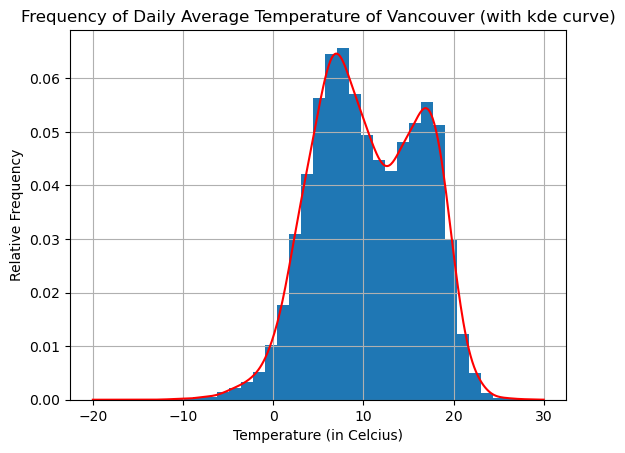

In [11]:
weather_df = pd.read_csv('data/vancouver_weather.csv')

weather_df.head()
weather_df["avg_temperature"].hist(bins=30,density=True)
plt.title('Frequency of Daily Average Temperature of Vancouver')
plt.xlabel('Temperature (in Celcius)'), plt.ylabel('Relative Frequency')
plt.show()
weather_kde = gaussian_kde(weather_df['avg_temperature'])
weather_df["avg_temperature"].hist(bins=30,density=True)
x = np.linspace(-20,30,500)
plt.plot(x,weather_kde.pdf(x),'r')
plt.title('Frequency of Daily Average Temperature of Vancouver (with kde curve)')
plt.xlabel('Temperature (in Celcius)'), plt.ylabel('Relative Frequency')
plt.show()

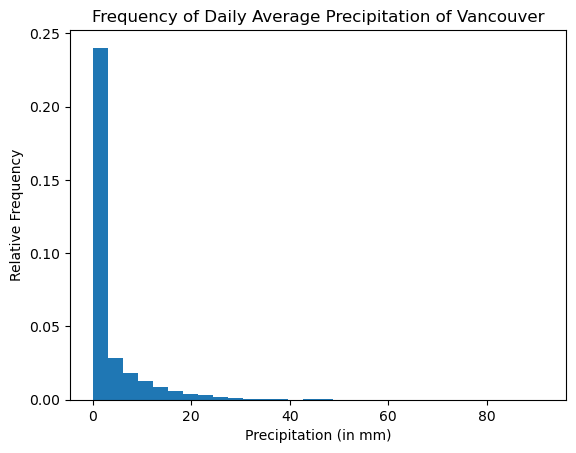

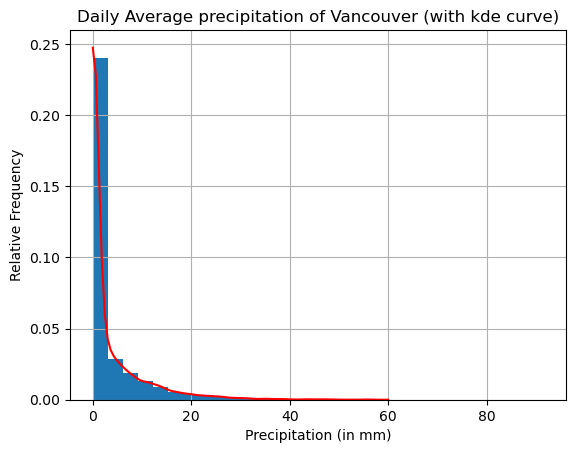

In [15]:
plt.hist(weather_df['precipitation'], bins = 30, density = True)
plt.title('Frequency of Daily Average Precipitation of Vancouver')
plt.xlabel('Precipitation (in mm)'), plt.ylabel('Relative Frequency')
plt.show()
Precipitation_kde = stats.gaussian_kde(weather_df["precipitation"])
weather_df["precipitation"].hist(bins=30,density=True)
x = np.linspace(0,60,100)
plt.plot(x,Precipitation_kde.pdf(x),'r')
plt.title('Daily Average precipitation of Vancouver (with kde curve)')
plt.xlabel('Precipitation (in mm)'), plt.ylabel('Relative Frequency')
plt.show()

In [6]:
T_min = weather_df['avg_temperature'].min()
T_max = weather_df['avg_temperature'].max()
P_min = weather_df['precipitation'].min()
P_max = weather_df['precipitation'].max()

print(weather_df['precipitation'].mean())

3.2037068239258635


In [7]:
weather_march = weather_df[weather_df['month'] == 3]

weather_march = weather_march[['year', 'avg_temperature', 'precipitation']]

weather_march = weather_march.groupby('year').mean().reset_index()

weather_march['consumer'] = 5742

weather_march.head()

,year,avg_temperature,precipitation,consumer
0,1997,6.274839,7.741935,5742
1,1998,7.885484,2.612903,5742
2,1999,6.345161,3.383871,5742
3,2000,6.967097,3.522581,5742
4,2001,6.636452,3.877419,5742


In [8]:
## c(T,P) = C_0 + a(T-T_0) - b(P-P_0)
## a,b based on the month of March

T_0 = weather_df['avg_temperature'].mean()
P_0 = weather_df['precipitation'].mean()
C_0 = 185.225
T = weather_march['avg_temperature'].mean()
P = weather_march['precipitation'].mean()
a = 4.6484
b = 1.6280

customer_march = np.max((C_0 + a * (T-T_0) - b * (P-P_0)),0)


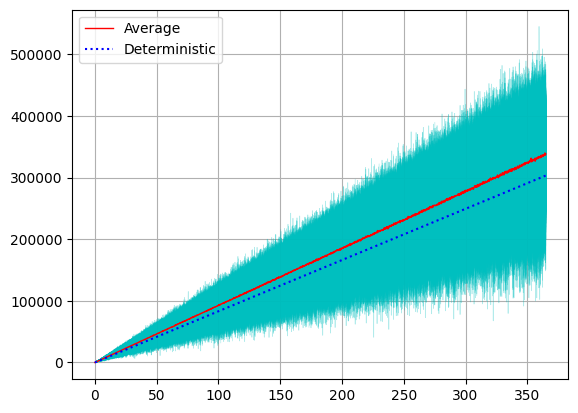

In [9]:
## Monte Carlo

t = np.linspace(0,365,2000)

N = 2000
Net_income_mc = []
income_per_person = 5

for i in range(N): 
    T = weather_kde.resample(N)
    P = np.random.exponential(weather_df['precipitation'].mean(), size = N)
    a_mc = a + np.random.normal(loc=0.0, scale=0.5364,size=1)
    b_mc = b + np.random.normal(loc=0.0, scale=0.3132,size=1)
    customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
    Num_customer = np.max(customer, 0)
    net_income = Num_customer * income_per_person * t
    Net_income_mc.append(net_income)
    plt.plot(t,net_income,'-c',alpha=0.3,linewidth=0.5)

Net_income_mc_ave = np.array(Net_income_mc)

Net_income_determin = (customer_march * income_per_person * t).flatten()

plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
plt.plot(t,Net_income_determin, ':b',linewidth=1.5,label='Deterministic')
plt.legend()
plt.grid(True)
plt.show()

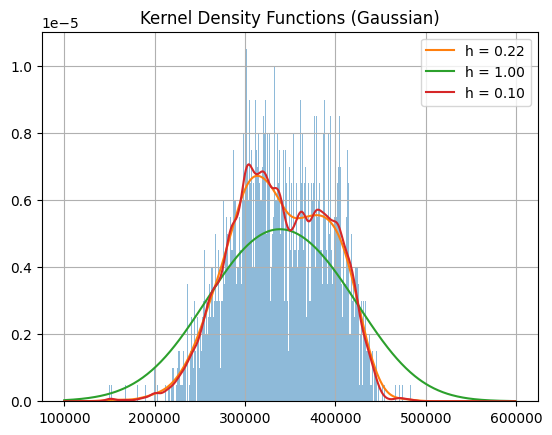

0.7419186264134212 0.6922705395266011 0.7461564808849397


In [10]:
Net_income_mc_end = Net_income_mc_ave[:,-1] #create a vertical slice at the last entry

plt.hist(Net_income_mc_end,bins=np.arange(100000,600000,1000),density=True,alpha=0.5)
kde1 = stats.gaussian_kde(Net_income_mc_end)
kde2 = stats.gaussian_kde(Net_income_mc_end,bw_method=1)
kde3 = stats.gaussian_kde(Net_income_mc_end,bw_method=0.1)

x = np.arange(100000,600000,1000)
plt.plot(x,kde1(x),label='h = {:.2f}'.format(kde1.factor))
plt.plot(x,kde2(x),label='h = 1.00')
plt.plot(x,kde3(x),label='h = 0.10')
plt.title('Kernel Density Functions (Gaussian)')
plt.legend()
plt.grid(True)
plt.show()


## probabilility that we make at least $300000 profit 
prob1 = kde1.integrate_box_1d(300000,np.inf)
prob2 = kde2.integrate_box_1d(300000,np.inf)
prob3 = kde3.integrate_box_1d(300000,np.inf)

print(prob1,prob2,prob3)

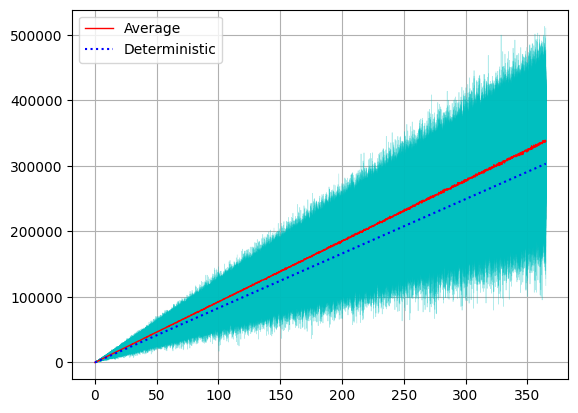

In [11]:

t = np.linspace(0,365,2000)

N = 2000
Net_income_mc = []
income_per_person = 5

for i in range(N): 
    T = weather_kde.resample(N)
    P = np.random.exponential(weather_df['precipitation'].mean(), size = N)
    a_mc = a + np.random.normal(loc=0.0, scale=0.5364,size=1)
    b_mc = b #+ np.random.normal(loc=0.0, scale=0.3132,size=1)
    customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
    Num_customer = np.max(customer, 0)
    net_income = Num_customer * income_per_person * t
    Net_income_mc.append(net_income)
    plt.plot(t,net_income,'-c',alpha=0.3,linewidth=0.5)

Net_income_mc_ave = np.array(Net_income_mc)

Net_income_determin = (customer_march * income_per_person * t).flatten()

plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
plt.plot(t,Net_income_determin, ':b',linewidth=1.5,label='Deterministic')
plt.legend()
plt.grid(True)
plt.show()

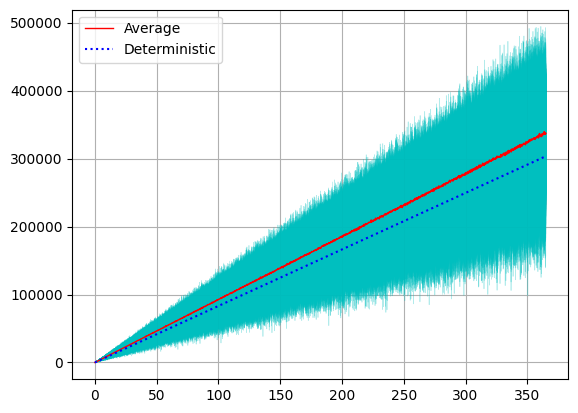

In [12]:

t = np.linspace(0,365,2000)

N = 2000
Net_income_mc = []
income_per_person = 5

for i in range(N): 
    T = weather_kde.resample(N)
    P = np.random.exponential(weather_df['precipitation'].mean(), size = N)
    a_mc = a #+ np.random.normal(loc=0.0, scale=0.5364,size=1)
    b_mc = b + np.random.normal(loc=0.0, scale=0.3132,size=1)
    customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
    Num_customer = np.max(customer, 0)
    net_income = Num_customer * income_per_person * t
    Net_income_mc.append(net_income)
    plt.plot(t,net_income,'-c',alpha=0.3,linewidth=0.5)

Net_income_mc_ave = np.array(Net_income_mc)

Net_income_determin = (customer_march * income_per_person * t).flatten()

plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
plt.plot(t,Net_income_determin, ':b',linewidth=1.5,label='Deterministic')
plt.legend()
plt.grid(True)
plt.show()